In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#download the dataset using the following commented user name and key
import opendatasets as od
import pandas
#weiya818
#24d636b51e5fc8edf57c030a556b0b04
od.download("https://www.kaggle.com/datasets/ansuld/fer2013plus-me")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: weiya818
Your Kaggle Key: ··········


100%|██████████| 36.2M/36.2M [00:02<00:00, 15.5MB/s]


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import keras
from keras.preprocessing import image
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [ ]:
#Codes cited form EECE571T Assignment 3

def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def move_to_cuda(x):
  x_cuda = tuple([torch.from_numpy(arr).cuda() for arr in x])
  return x_cuda

def gray_to_color(x):
    return x.repeat(3, 1, 1)

def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/fer2013plus-me/train"
test_dir = "/content/fer2013plus-me/test"
validation_dir="/content/fer2013plus-me/val"

img_size=48

In [ ]:
def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + "/" + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
neutral,10390,1279
happiness,7539,929
surprise,3588,446
sadness,3549,448
anger,2478,326
fear,656,94
disgust,194,23
contempt,167,29


<Axes: >

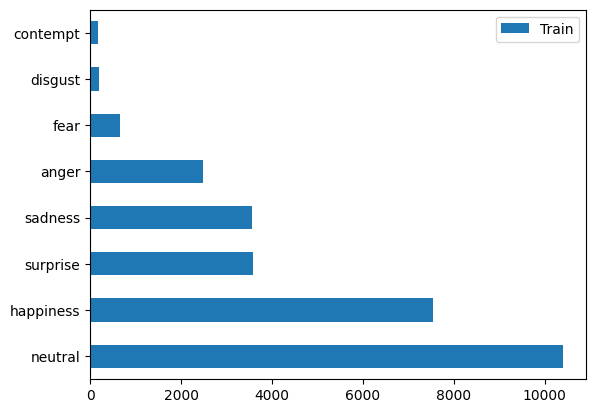

In [ ]:
Train_Count.plot(kind='barh')

<Axes: >

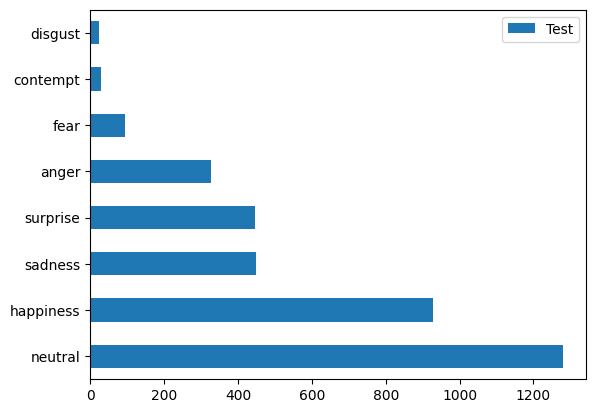

In [ ]:
Test_Count.plot(kind='barh')

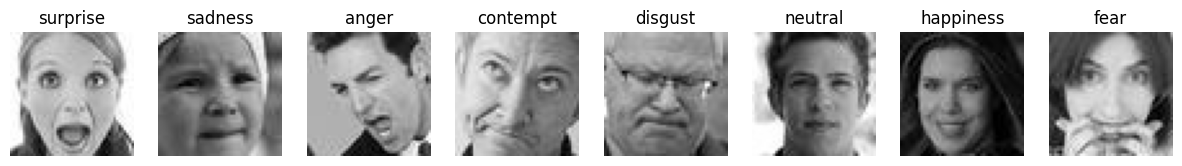

In [ ]:
i=1
plt.figure(figsize=(15, 5))
for folder in os.listdir(train_dir):

    img = load_img((train_dir +"/"+ folder +'/'+ os.listdir(train_dir + "/"+ folder)[1]))
    plt.subplot(1,8,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_iter = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (img_size,img_size),
    batch_size = 64,
    class_mode = "categorical",
    subset = "training",
)
validation_iter = validation_datagen.flow_from_directory(
    directory = validation_dir,
    target_size = (img_size, img_size),
    batch_size = 64,
    class_mode = 'categorical',
)
test_iter = test_datagen.flow_from_directory( directory = test_dir,
    target_size = (img_size,img_size),
    batch_size = 64,
    class_mode = "categorical",
)

Found 28561 images belonging to 8 classes.
Found 3579 images belonging to 8 classes.
Found 3574 images belonging to 8 classes.


In [ ]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding='same')
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout1 = nn.Dropout2d(p=0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding='same')
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout2 = nn.Dropout2d(p=0.2)

        self.conv4 = nn.Conv2d(128, 512, kernel_size=3, stride=1, padding='same')
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout3 = nn.Dropout2d(p=0.2)
#version 4
        # self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding='same')
        # self.relu4 = nn.ReLU()
        # self.bn4 = nn.BatchNorm2d(512)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)
        # self.dropout4 = nn.Dropout2d(p=0.2)

        self.fc1 = nn.Linear(512*45*45, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 512)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(512, 2)


    def forward(self, input):
        input = input.permute(0, 3, 1, 2)
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv4(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
#version 4
        # x = self.conv5(x)
        # x = self.relu4(x)
        # x = self.bn4(x)
        # x = self.pool4(x)
        # x = self.dropout4(x)

        #print(x.size(0))
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        #x = nn.functional.sigmoid(x)
        x = self.relu5(x)
        x = self.fc2(x)
        #x = nn.functional.sigmoid(x)
        x = self.relu6(x)
        x = self.fc3(x)
        pred_label = nn.functional.log_softmax(x, dim=1)

        return {'label': pred_label}

In [ ]:
def my_loss_function(prediction, target):
  one_hot = target.long()
  new_one_hot = torch.zeros(target.shape[0], 2).cuda()
  new_one_hot[:, 0] = torch.sum(one_hot[:, [0, 3, 4, 7]], dim=1)
  new_one_hot[:, 1] = torch.sum(one_hot[:, [1, 2, 5, 6]], dim=1)

  loss = nn.CrossEntropyLoss()(prediction, new_one_hot)
  return loss

In [ ]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = move_to_cuda(batch_cpu)
        pred = network(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)

        one_hot = batch_gpu[1].long()
        new_one_hot = torch.zeros(batch_gpu[1].shape[0], 2).cuda()
        new_one_hot[:, 0] = torch.sum(one_hot[:, [0, 3, 4, 7]], dim=1)
        new_one_hot[:, 1] = torch.sum(one_hot[:, [1, 2, 5, 6]], dim=1)
        ground_truth = new_one_hot.argmax(dim=1,keepdim=True)

        correct += pred.eq(ground_truth.view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

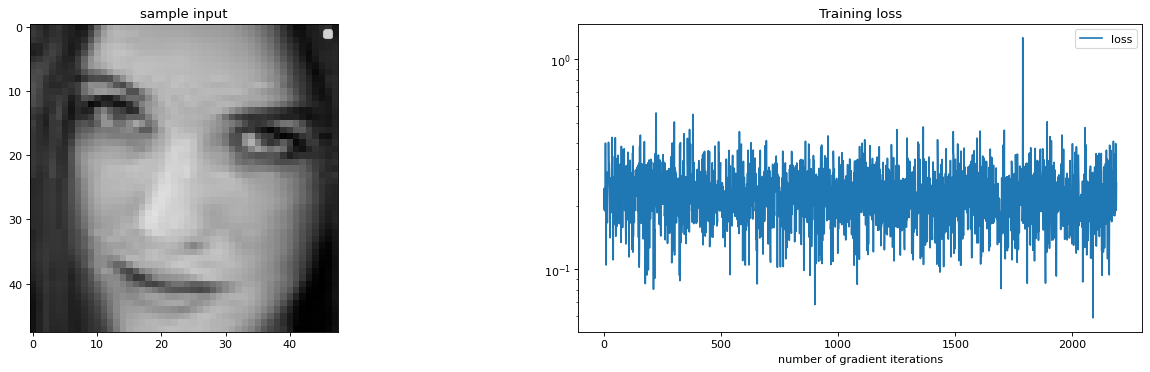

Test accuracy is:  0.8894795747062115
Training epoch 4, iteration 400 of 447 (89 %), loss=0.2583685517311096


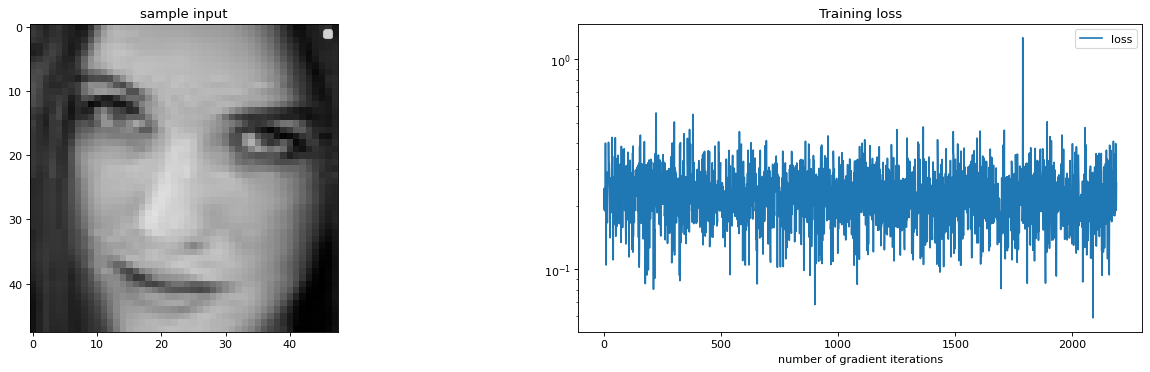

In [ ]:
#Codes cited from EECE571T Assignment 2
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

# network = MyNetwork().to('cuda')
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)
train_losses = []
val_losses = []
num_epochs = 5
for e in range(num_epochs):
    network.train()
    for i in range(len(train_iter)):
        batch_cpu = next(train_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        image = torch.tensor(batch_cpu[0])
        image = image.permute(0, 3, 1, 2)
        pred = network(batch_gpu[0])
        pred_cpu = dict_to_device(pred, 'cpu')

        loss = my_loss_function(pred['label'], batch_gpu[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(image[0], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Test accuracy is: ", get_accuracy(network, test_iter))
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_iter), 100*i//len(train_iter), train_losses[-1]))


In [ ]:
print("Train accuracy is: ", get_accuracy(network, train_iter))
print("Validation accuracy is: ", get_accuracy(network, validation_iter))

Train accuracy is:  0.8888344245649662
Validation accuracy is:  0.8871193070690137


In [ ]:
print("Test accuracy is: ", get_accuracy(network, test_iter))

Test accuracy is:  0.8808058198097369


tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1.])
tensor([0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])


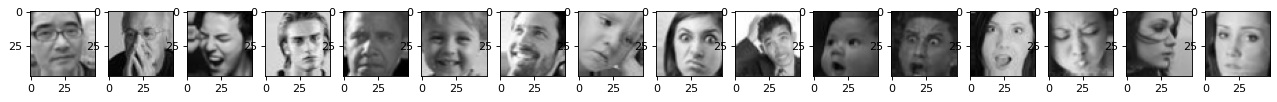

In [ ]:
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1, 16)
batch = next(train_iter)
image = torch.tensor(batch[0])
result = torch.tensor(batch[1])
image = image.permute(0, 3, 1, 2)

for i in range(16):
  plot_images(image[i], ax=axes[i])
  print(result[i])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(network.state_dict(), '/content/drive/MyDrive/my_model_split.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

# Load the saved model from file

network = MyNetwork().to('cuda')
network.load_state_dict(torch.load('/content/drive/MyDrive/my_model_split.pth'))

# Set the model to evaluation mode
network.eval()

print(get_accuracy(network, test_iter))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


0.8808058198097369


In [ ]:
class1_X_train = []
class2_X_train = []
class1_y_train = []
class2_y_train = []
network.eval()
for i in range(len(train_iter)):
  batch_cpu = next(train_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  image = torch.tensor(batch_cpu[0])
  image = image.permute(0, 3, 1, 2)
  pred = network(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  pred = pred.cpu().numpy().flatten()

  subset1_idx = (pred == 0).nonzero()[0]
  subset2_idx = (pred == 1).nonzero()[0]

  subset1_X = batch_cpu[0][subset1_idx]
  subset2_X = batch_cpu[0][subset2_idx]
  subset1_y = batch_cpu[1][subset1_idx]
  subset2_y = batch_cpu[1][subset2_idx]
  class1_X_train.extend(subset1_X)
  class2_X_train.extend(subset2_X)
  class1_y_train.extend(subset1_y)
  class2_y_train.extend(subset2_y)


class1_X_val = []
class2_X_val = []
class1_y_val = []
class2_y_val = []
network.eval()
for i in range(len(validation_iter)):
  batch_cpu = next(validation_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  image = torch.tensor(batch_cpu[0])
  image = image.permute(0, 3, 1, 2)
  pred = network(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  pred = pred.cpu().numpy().flatten()

  subset1_idx = (pred == 0).nonzero()[0]
  subset2_idx = (pred == 1).nonzero()[0]

  subset1_X = batch_cpu[0][subset1_idx]
  subset2_X = batch_cpu[0][subset2_idx]
  subset1_y = batch_cpu[1][subset1_idx]
  subset2_y = batch_cpu[1][subset2_idx]
  class1_X_val.extend(subset1_X)
  class2_X_val.extend(subset2_X)
  class1_y_val.extend(subset1_y)
  class2_y_val.extend(subset2_y)




In [ ]:
class1_X_train = torch.tensor(class1_X_train)
class2_X_train = torch.tensor(class2_X_train)
class1_y_train = torch.tensor(class1_y_train)
class2_y_train = torch.tensor(class2_y_train)
class1_X_val = torch.tensor(class1_X_val)
class2_X_val = torch.tensor(class2_X_val)
class1_y_val = torch.tensor(class1_y_val)
class2_y_val = torch.tensor(class2_y_val)

<ipython-input-16-462cb917b4fa>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  class1_X_train = torch.tensor(class1_X_train)


In [ ]:
print(len(class1_X_train))
print(len(class2_X_train))
print(len(class1_y_train))
print(len(class2_y_train))
print(len(class1_X_val))
print(len(class2_X_val))
print(len(class1_y_val))
print(len(class2_y_val))
print(image.shape)
print(type(batch_cpu[0]))
print(type(class2_X_train))

13295
15266
13295
15266
1633
1946
1633
1946
torch.Size([59, 3, 48, 48])
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [ ]:
torch.save(class1_X_train, '/content/drive/MyDrive/class1_X_train.pt')
torch.save(class1_y_train, '/content/drive/MyDrive/class1_y_train.pt')
torch.save(class1_X_val, '/content/drive/MyDrive/class1_X_val.pt')
torch.save(class1_y_val, '/content/drive/MyDrive/class1_y_val.pt')
torch.save(class2_X_train, '/content/drive/MyDrive/class2_X_train.pt')
torch.save(class2_y_train, '/content/drive/MyDrive/class2_y_train.pt')
torch.save(class2_X_val, '/content/drive/MyDrive/class2_X_val.pt')
torch.save(class2_y_val, '/content/drive/MyDrive/class2_y_val.pt')

In [ ]:
class1_X_train = torch.load('/content/drive/My Drive/class1_X_train.pt')
class1_y_train = torch.load('/content/drive/My Drive/class1_y_train.pt')
class1_X_val = torch.load('/content/drive/My Drive/class1_X_val.pt')
class1_y_val = torch.load('/content/drive/My Drive/class1_y_val.pt')
class2_X_train = torch.load('/content/drive/My Drive/class2_X_train.pt')
class2_y_train = torch.load('/content/drive/My Drive/class2_y_train.pt')
class2_X_val = torch.load('/content/drive/My Drive/class2_X_val.pt')
class2_y_val = torch.load('/content/drive/My Drive/class2_y_val.pt')

In [ ]:
class ClassNetwork(nn.Module):
    def __init__(self):
        super(ClassNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding='same')
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout1 = nn.Dropout2d(p=0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding='same')
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout2 = nn.Dropout2d(p=0.2)

        self.conv4 = nn.Conv2d(128, 512, kernel_size=3, stride=1, padding='same')
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout3 = nn.Dropout2d(p=0.2)
#version 4
        # self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding='same')
        # self.relu4 = nn.ReLU()
        # self.bn4 = nn.BatchNorm2d(512)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)
        # self.dropout4 = nn.Dropout2d(p=0.2)

        self.fc1 = nn.Linear(512*45*45, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 512)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(512, 8)


    def forward(self, input):
        input = input.permute(0, 3, 1, 2)
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv4(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
#version 4
        # x = self.conv5(x)
        # x = self.relu4(x)
        # x = self.bn4(x)
        # x = self.pool4(x)
        # x = self.dropout4(x)

        #print(x.size(0))
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.relu6(x)
        relu6_output = x.detach()
        x = self.fc3(x)
        pred_label = nn.functional.log_softmax(x, dim=1)

        return {'label': pred_label, 'relu6': relu6_output}

In [ ]:
def batch_iterator(data, labels, batch_size):
    num_samples = len(data)
    indices = torch.randperm(num_samples)
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_indices = indices[start:end]
        batch_data = data[batch_indices]
        batch_labels = labels[batch_indices]
        yield batch_data, batch_labels

In [ ]:
class1_datagen = ImageDataGenerator(
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         #rescale = 1./255,
                                         #zoom_range = 0.2,
                                         #validation_split = 0.2
                                        )
class1_iter = class1_datagen.flow(class1_X_train, class1_y_train, batch_size=64)

In [ ]:
def class_loss_function(prediction, target):
  loss = nn.CrossEntropyLoss()(prediction, target)
  return loss

In [ ]:
def get_class_accuracy(network, class_X, class_y):
    network.eval()
    correct = 0
    total = 0
    for batch_data, batch_labels in batch_iterator(class_X, class_y, 64):
        batch_data = batch_data.cuda()
        batch_labels = batch_labels.cuda()
        pred = network(batch_data)['label'].argmax(dim=1, keepdim=True)
        ground_truth = batch_labels.argmax(dim=1,keepdim=True)
        correct += pred.eq(ground_truth.view_as(pred)).sum().item()
        total += pred.shape[0]
    return correct / total

In [ ]:
import torch

# Load the saved model from file

network_class1 = ClassNetwork().to('cuda')
network_class1.load_state_dict(torch.load('/content/drive/MyDrive/my_model_best_v5.pth'))

# Set the model to evaluation mode
network_class1.eval()

print(get_class_accuracy(network_class1, class1_X_val, class1_y_val))

0.8462951622780159


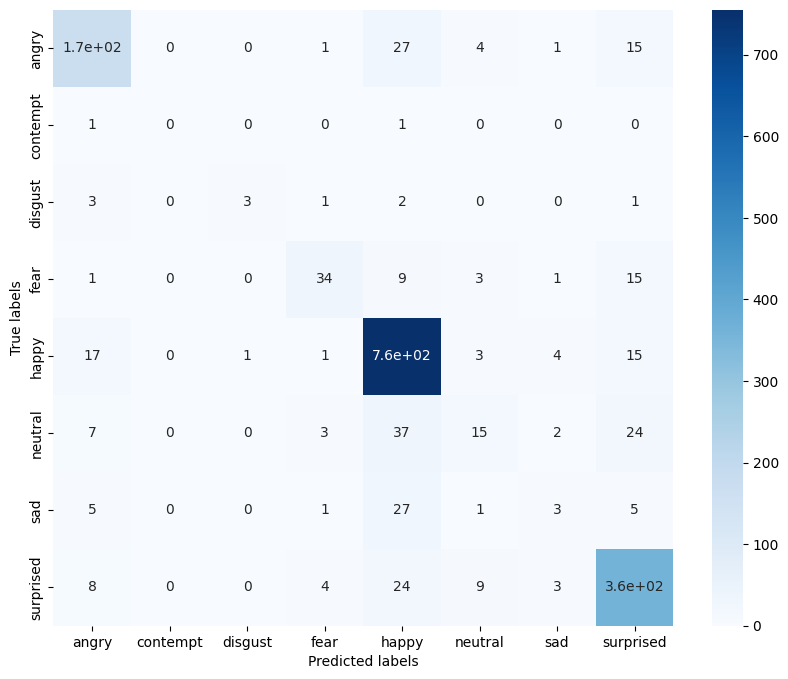

In [ ]:
from sklearn.metrics import confusion_matrix
class1_datagen = ImageDataGenerator()
class1_iter = class1_datagen.flow(class1_X_val, class1_y_val, batch_size=64)
confusion_matrix = torch.zeros(8, 8).cuda()
for i in range(len(class1_iter)):
  batch_cpu = next(class1_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  pred = network_class1(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
  for j in range(len(pred)):
    confusion_matrix[ground_truth[j], pred[j]] += 1

# Define class labels
labels = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Create heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

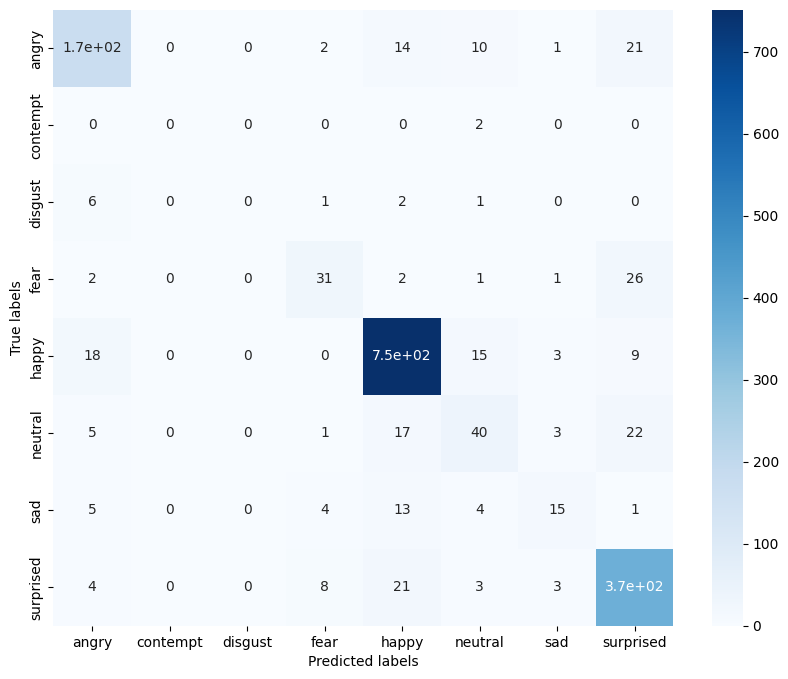

In [ ]:
from sklearn.metrics import confusion_matrix
class1_datagen = ImageDataGenerator()
class1_iter = class1_datagen.flow(class1_X_val, class1_y_val, batch_size=64)
confusion_matrix = torch.zeros(8, 8).cuda()
for i in range(len(class1_iter)):
  batch_cpu = next(class1_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  pred = network_class1(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
  for j in range(len(pred)):
    confusion_matrix[ground_truth[j], pred[j]] += 1

# Define class labels
labels = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Create heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

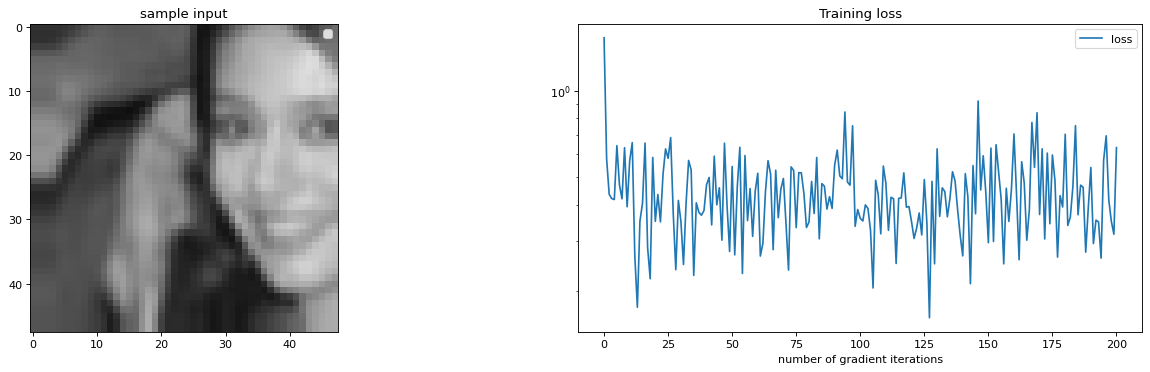

0.8003674219228414
Training epoch 0, iteration 200 of 447 (44 %), loss=0.6325773000717163
0.8971793907484017


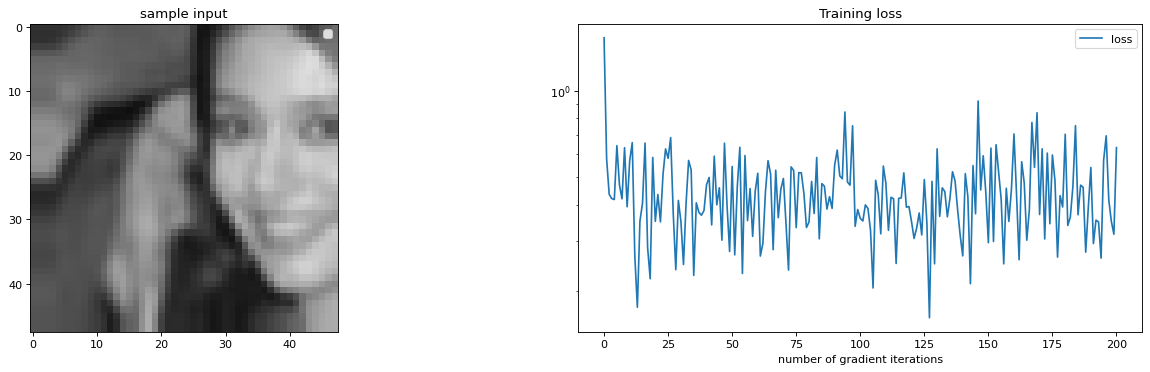

In [ ]:
#Code structure cited from EECE571T Assignment2, some changes included here
%matplotlib inline
from IPython import display
# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

#network_class1 = ClassNetwork().to('cuda')
optimizer = torch.optim.Adam(network_class1.parameters(), lr=0.0001)
train_losses = []
val_losses = []
num_epochs = 1
for e in range(num_epochs):
    network_class1.train()
    i = 0
    # for batch_data, batch_labels in batch_iterator(class1_X_train, class1_y_train, 64):
    for i in range(len(class1_iter)):
        batch_cpu = next(class1_iter)
        batch_data =  torch.from_numpy(batch_cpu[0])
        batch_labels = torch.from_numpy(batch_cpu[1])
        # print(batch_data.shape)
        image = batch_data.permute(0, 3, 1, 2)
        batch_data = batch_data.cuda()
        batch_labels = batch_labels.cuda()
        # print(batch_data.shape)
        pred = network_class1(batch_data)
        pred_cpu = dict_to_device(pred, 'cpu')
        # calculate the loss and backward the gradient
        loss = class_loss_function(pred['label'], batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(image[0], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            val_acc = get_class_accuracy(network_class1,class1_X_val, class1_y_val)
            print(val_acc )
            if(val_acc > 0.824):
              torch.save(network_class1.state_dict(), '/content/drive/MyDrive/my_model_class1.pth')
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_iter), 100*i//len(train_iter), train_losses[-1]))
        i += 1
    print(get_class_accuracy(network_class1,class1_X_train, class1_y_train))

In [ ]:
print(get_class_accuracy(network_class1,class1_X_train, class1_y_train))
print(get_class_accuracy(network_class1,class1_X_val, class1_y_val))

0.8971793907484017
0.8058787507654623


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(network_class1.state_dict(), '/content/drive/MyDrive/my_model_class1.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class2_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                        #  rescale = 1./255,
                                         #zoom_range = 0.2,
                                         #validation_split = 0.2
                                        )
class2_iter = class2_datagen.flow(class2_X_train, class2_y_train, batch_size=64)

In [ ]:
network_class2 = ClassNetwork().to('cuda')
network_class2.load_state_dict(torch.load('/content/drive/MyDrive/my_model_best_v5.pth'))
print(get_class_accuracy(network_class2, class2_X_val, class2_y_val))

0.7261048304213772


In [ ]:
print(get_class_accuracy(network_class2, class2_X_train, class2_y_train))

0.8349927944451723


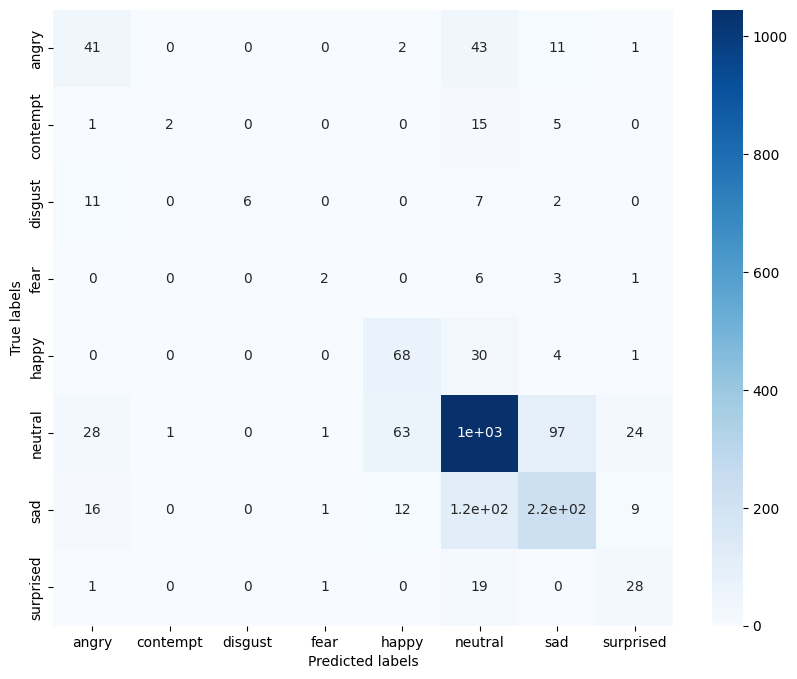

In [ ]:
from sklearn.metrics import confusion_matrix
class2_datagen = ImageDataGenerator()
class2_iter = class2_datagen.flow(class2_X_val, class2_y_val, batch_size=64)
confusion_matrix = torch.zeros(8, 8).cuda()
for i in range(len(class2_iter)):
  batch_cpu = next(class2_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  pred = network_class2(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
  for j in range(len(pred)):
    confusion_matrix[ground_truth[j], pred[j]] += 1

# Define class labels
labels = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Create heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

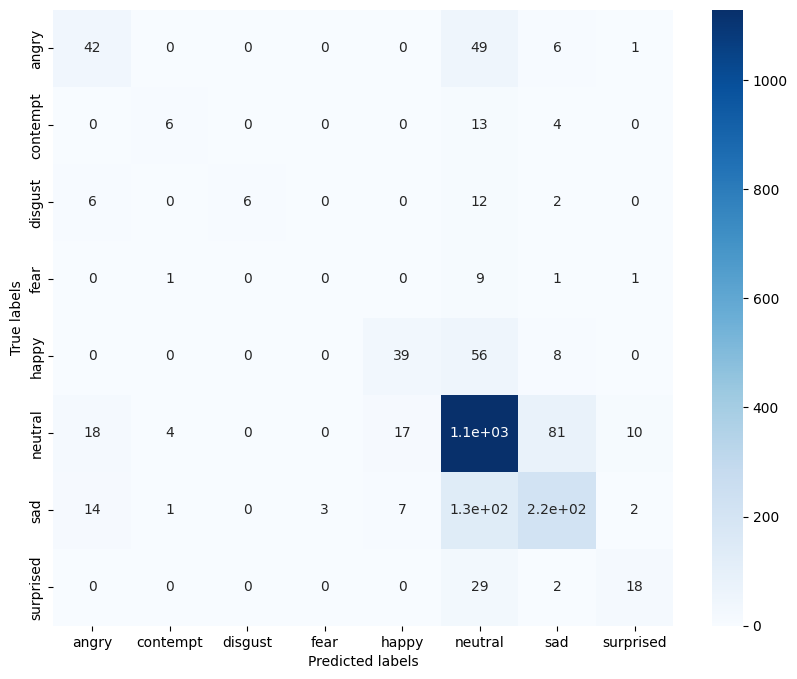

In [ ]:
from sklearn.metrics import confusion_matrix
class2_datagen = ImageDataGenerator()
class2_iter = class2_datagen.flow(class2_X_val, class2_y_val, batch_size=64)
confusion_matrix = torch.zeros(8, 8).cuda()
for i in range(len(class2_iter)):
  batch_cpu = next(class2_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  pred = network_class2(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
  for j in range(len(pred)):
    confusion_matrix[ground_truth[j], pred[j]] += 1

# Define class labels
labels = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Create heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

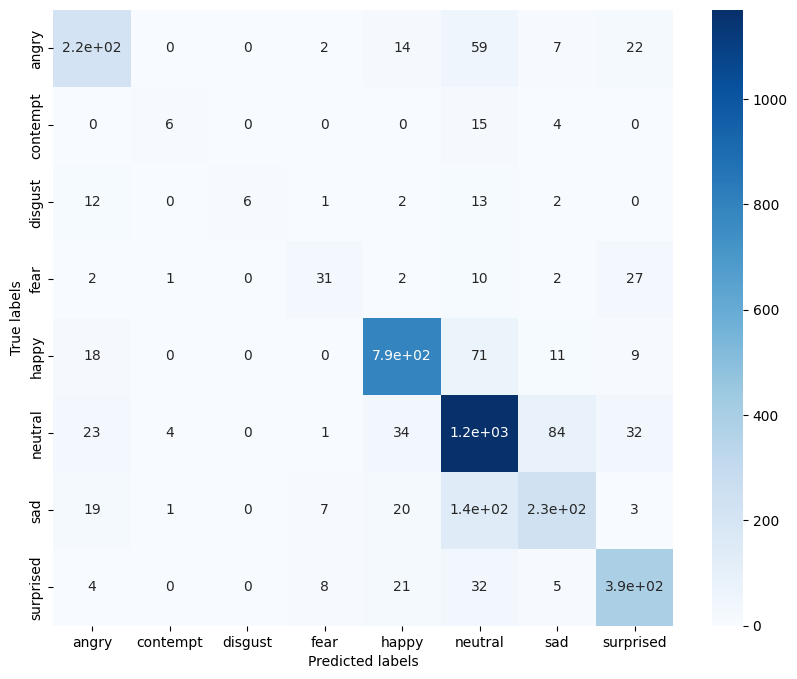

In [ ]:
#OVERALL CONFUSION MATRIX
class1_datagen = ImageDataGenerator()
class1_iter = class1_datagen.flow(class1_X_val, class1_y_val, batch_size=64)
class2_datagen = ImageDataGenerator()
class2_iter = class2_datagen.flow(class2_X_val, class2_y_val, batch_size=64)
confusion_matrix = torch.zeros(8, 8).cuda()
for i in range(len(class1_iter)):
  batch_cpu = next(class1_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  pred = network_class1(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
  for j in range(len(pred)):
    confusion_matrix[ground_truth[j], pred[j]] += 1

for i in range(len(class2_iter)):
  batch_cpu = next(class2_iter)
  batch_gpu = move_to_cuda(batch_cpu)
  pred = network_class2(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
  ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
  for j in range(len(pred)):
    confusion_matrix[ground_truth[j], pred[j]] += 1
# Define class labels
labels = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Create heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


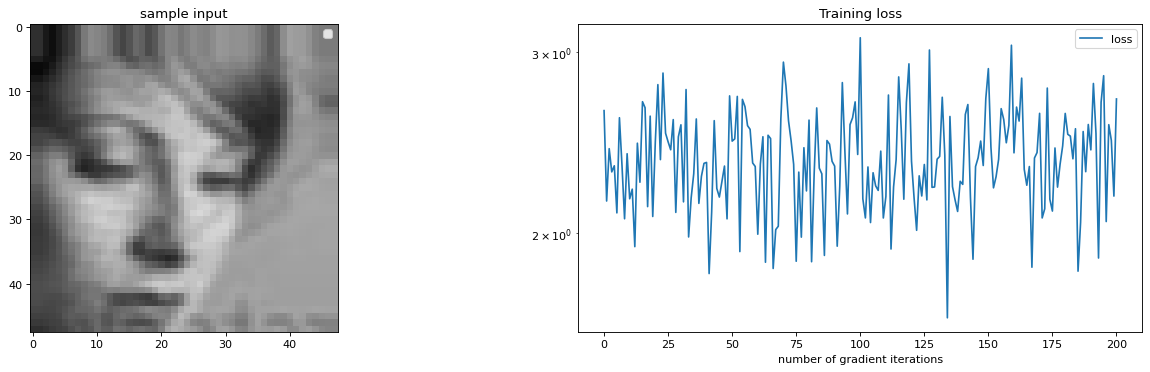

0.7482014388489209
Training epoch 0, iteration 200 of 447 (44 %), loss=2.699188709259033
0.8347307742696187


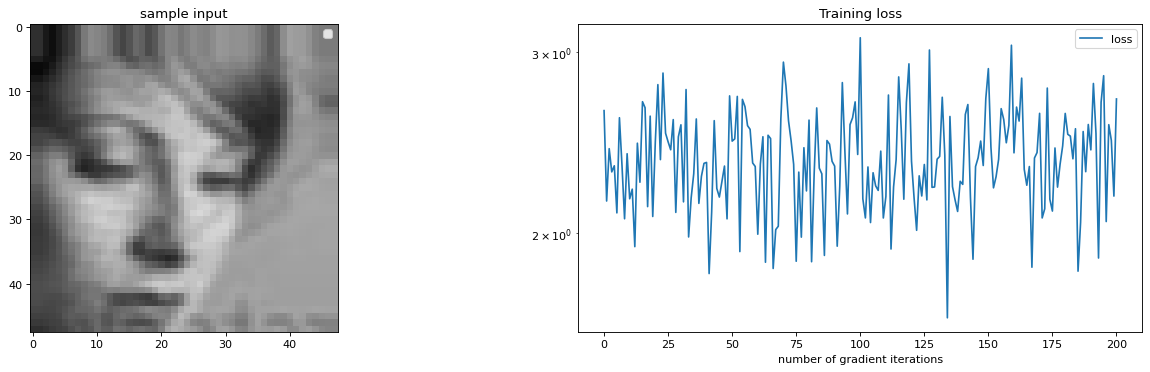

In [ ]:
#Code structure cited from EECE571T Assignment2, some changes included here
%matplotlib inline
from IPython import display
# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

#network_class2 = ClassNetwork().to('cuda')
optimizer = torch.optim.Adam(network_class2.parameters(), lr=0.0001)
train_losses = []
val_losses = []
num_epochs = 1
for e in range(num_epochs):
    network_class2.train()
    i = 0
    # for batch_data, batch_labels in batch_iterator(class2_X_train, class2_y_train, 64):
    for i in range(len(class2_iter)):
        batch_cpu = next(class2_iter)
        batch_data =  torch.from_numpy(batch_cpu[0])
        batch_labels = torch.from_numpy(batch_cpu[1])

        image = batch_data.permute(0, 3, 1, 2)
        batch_data = batch_data.cuda()
        batch_labels = batch_labels.cuda()

        pred = network_class1(batch_data)
        pred_cpu = dict_to_device(pred, 'cpu')
        # calculate the loss and backward the gradient
        loss = class_loss_function(pred['label'], batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(image[0], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            val_acc = get_class_accuracy(network_class2,class2_X_val, class2_y_val)
            print(val_acc )
            if(val_acc > 0.748):
              torch.save(network_class2.state_dict(), '/content/drive/MyDrive/my_model_class2.pth')
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_iter), 100*i//len(train_iter), train_losses[-1]))
        i += 1
    print(get_class_accuracy(network_class2,class2_X_train, class2_y_train))

In [ ]:
print(get_class_accuracy(network_class2, class2_X_train, class2_y_train))
print(get_class_accuracy(network_class2, class2_X_val, class2_y_val))

0.8515655705489322
0.7219938335046249


In [ ]:
import torch

# Load the saved model from file

network_class2 = ClassNetwork().to('cuda')
network_class2.load_state_dict(torch.load('/content/drive/MyDrive/my_model_class2_new.pth'))

# Set the model to evaluation mode
network_class2.eval()
print(get_class_accuracy(network_class2, class2_X_val, class2_y_val))

0.7482014388489209


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(network_class2.state_dict(), '/content/drive/MyDrive/my_model_class2.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Transfer Learning:**

In [ ]:
import os
import torch
import numpy as np
from PIL import Image

label_names = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Load the saved model
import torch
network = ClassNetwork().to('cuda')
network.load_state_dict(torch.load('/content/drive/MyDrive/my_model_best_v5.pth'))


def predict_folder(network, folder_path):
    network.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    network.to(device)
    correct_count = 0
    total_count = 0

    label_names = os.listdir(folder_path)
    label_names.sort()  # Sort the labels for consistency

    for label in label_names:
        image_folder = os.path.join(folder_path, label)
        if not os.path.isdir(image_folder):
            continue  # Skip non-directory files
        for filename in os.listdir(image_folder):
            file_path = os.path.join(image_folder, filename)
            if not os.path.isfile(file_path) or filename.startswith('.'):
                continue  # Skip non-file items and files starting with '.'
            try:
                img = Image.open(file_path)
                img_arr = np.array(img)
                img_arr = img_arr[np.newaxis, :]
                img_arr = img_arr / 255.0
                img_tensor = torch.from_numpy(img_arr).float().to(device)

                output = network(img_tensor)
                _, predicted = torch.max(output['label'], 1)
                prediction = predicted.item()

                true_label = label_names.index(label)
                print(f"File: {file_path}")
                print(f"Predicted Label: {prediction}, True Label: {true_label}")

                if prediction == true_label:
                    correct_count += 1
                total_count += 1
            except:
                print(f"Failed to process image: {file_path}")

    accuracy = (correct_count / total_count) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

predict_folder(network, '/content/drive/MyDrive/TestData')

File: /content/drive/MyDrive/TestData/angry/IMG_0157.jpg
Predicted Label: 0, True Label: 0
File: /content/drive/MyDrive/TestData/angry/IMG_0155.jpg
Predicted Label: 5, True Label: 0
File: /content/drive/MyDrive/TestData/angry/IMG_0154.jpg
Predicted Label: 5, True Label: 0
File: /content/drive/MyDrive/TestData/angry/IMG_0152.jpg
Predicted Label: 4, True Label: 0
File: /content/drive/MyDrive/TestData/angry/IMG_0151.jpg
Predicted Label: 4, True Label: 0
File: /content/drive/MyDrive/TestData/angry/FullSizeRender 14.jpg
Predicted Label: 5, True Label: 0
File: /content/drive/MyDrive/TestData/angry/FullSizeRender 11.jpg
Predicted Label: 7, True Label: 0
File: /content/drive/MyDrive/TestData/contempt/IMG_0166.jpg
Predicted Label: 5, True Label: 1
File: /content/drive/MyDrive/TestData/contempt/IMG_0165.jpg
Predicted Label: 5, True Label: 1
File: /content/drive/MyDrive/TestData/contempt/IMG_0164.jpg
Predicted Label: 5, True Label: 1
File: /content/drive/MyDrive/TestData/contempt/FullSizeRender 1

63.63636363636363

In [ ]:
def get_tf_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = move_to_cuda(batch_cpu)
        pred = network(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
        ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
        correct += pred.eq(ground_truth.view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

Found 278 images belonging to 8 classes.


NameError: ignored

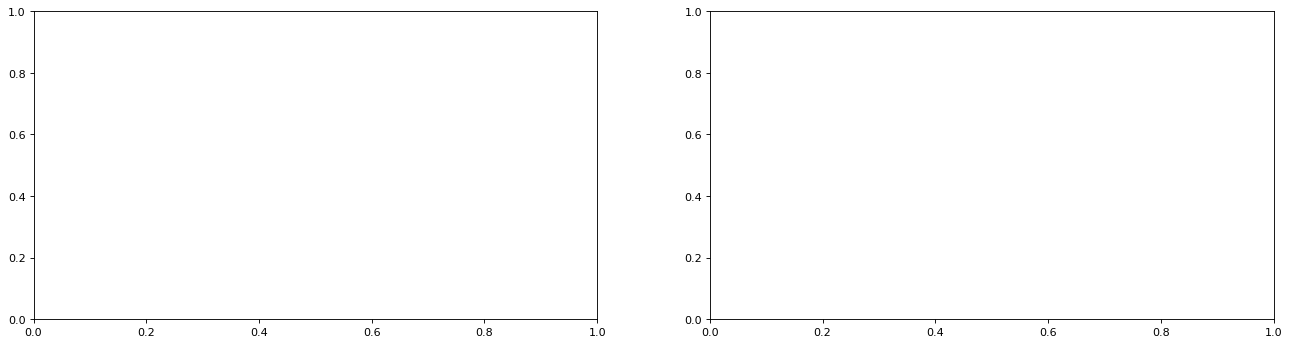

In [ ]:
%matplotlib inline
from IPython import display

tf_train_dir = "/content/drive/MyDrive/TransferLearningDataset"
tf_train_datagen = ImageDataGenerator(      width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                        )
tf_train_iter = tf_train_datagen.flow_from_directory(
    directory = tf_train_dir,
    target_size = (48,48),
    batch_size = 64,
    class_mode = "categorical",
    subset = "training"
)

tf_network = ClassNetwork().to('cuda')
tf_network.load_state_dict(network.state_dict())
# Freeze the layers of the pre-trained model
for param in tf_network.parameters():
    param.requires_grad = False
# Modify the last layer of the new model for your new dataset
tf_network.fc3 = nn.Linear(512, 8)  # Replace num_classes with the number of classes in your new dataset
tf_network = tf_network.to('cuda')

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

optimizer = torch.optim.Adam(tf_network.parameters(), lr=0.0001)
train_losses = []
val_losses = []
num_epochs = 10
for e in range(num_epochs):
    tf_network.train()
    for i in range(len(train_iter)):
        batch_cpu = next(train_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        image = torch.tensor(batch_cpu[0])
        image = image.permute(0, 3, 1, 2)
        pred = network(batch_gpu[0])
        pred_cpu = dict_to_device(pred, 'cpu')

        loss = class_loss_function(pred['label'], batch_gpu[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(image[0], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print(get_tf_accuracy(tf_network, train_iter))
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_iter), 100*i//len(train_iter), train_losses[-1]))


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# tf_train_dir = "/content/fer2013plus-me/train"
# tf_train_dir = "/content/drive/MyDrive/TransferLearningTrain"
# tf_train_dir = "/content/drive/MyDrive/TransferLearningTrain_Version2"
tf_train_dir = "/content/drive/MyDrive/TransferLearningComparison_Version2"
tf_train_datagen = ImageDataGenerator(     # width_shift_range = 0.1,
                                        #  height_shift_range = 0.1,
                                        #  horizontal_flip = True,
                                         rescale = 1./255,
                                        )
tf_train_iter = tf_train_datagen.flow_from_directory(
    directory = tf_train_dir,
    target_size = (48,48),
    batch_size = 275,
    class_mode = "categorical",
    subset = "training"
)

# tf_val_dir = "/content/fer2013plus-me/val"
# tf_val_dir = "/content/drive/MyDrive/TestData"
tf_val_dir = "/content/drive/MyDrive/TestData_Version2"
tf_val_datagen = ImageDataGenerator(rescale=1./255)
tf_val_iter = tf_val_datagen.flow_from_directory(
    directory = tf_val_dir,
    target_size = (48, 48),
    batch_size = 102,
    class_mode = 'categorical',
)

tf_network = ClassNetwork().to('cuda')
tf_network.load_state_dict(network.state_dict())
tf_network.eval()
batch_cpu = next(tf_train_iter)
batch_gpu = move_to_cuda(batch_cpu)
with torch.no_grad():
    features_train = tf_network(batch_gpu[0])['relu6']

pca = PCA(n_components=20)
features_train_pca = pca.fit_transform(features_train.cpu())

# Train an SVM model on the extracted features
svm_model = svm.SVC()
svm_model.fit(features_train_pca, batch_gpu[1].argmax(dim=1,keepdim=True).cpu())

# Make predictions using the SVM model
batch_cpu = next(tf_val_iter)
batch_gpu = move_to_cuda(batch_cpu)
with torch.no_grad():
    features_test = tf_network(batch_gpu[0])['relu6']
features_test_pca = pca.transform(features_test.cpu())

y_pred = svm_model.predict(features_test_pca)
ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True).cpu()

accuracy = accuracy_score(y_pred, ground_truth)
print(f"Accuracy: {accuracy:.4f}")

Found 275 images belonging to 8 classes.
Found 102 images belonging to 8 classes.


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.5588


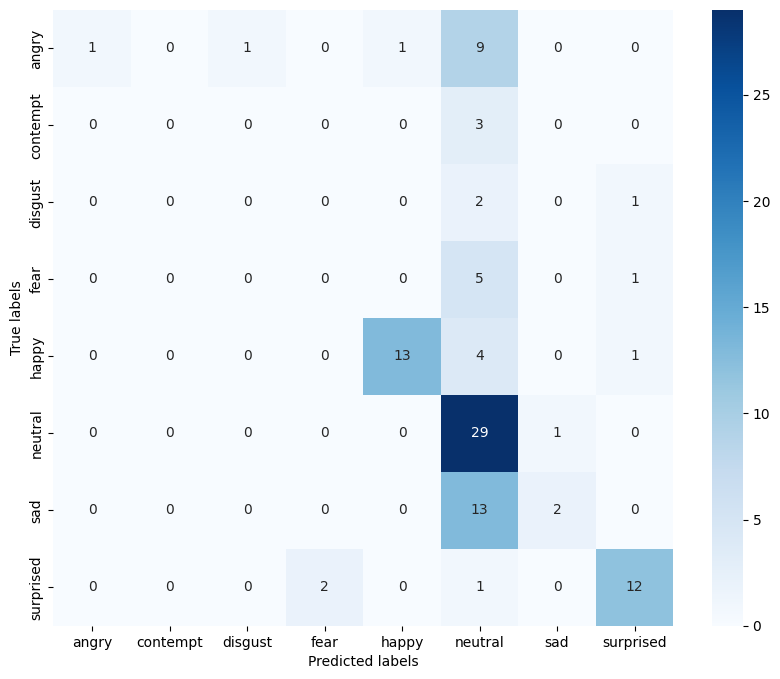

In [ ]:
confusion_matrix = torch.zeros(8, 8).cuda()
batch_cpu = next(tf_val_iter)
batch_gpu = move_to_cuda(batch_cpu)
with torch.no_grad():
    features_test = tf_network(batch_gpu[0])['relu6']
features_test_pca = pca.transform(features_test.cpu())
pred = svm_model.predict(features_test_pca)
ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
for j in range(len(pred)):
  confusion_matrix[ground_truth[j], pred[j]] += 1

# Define class labels
labels = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Create heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

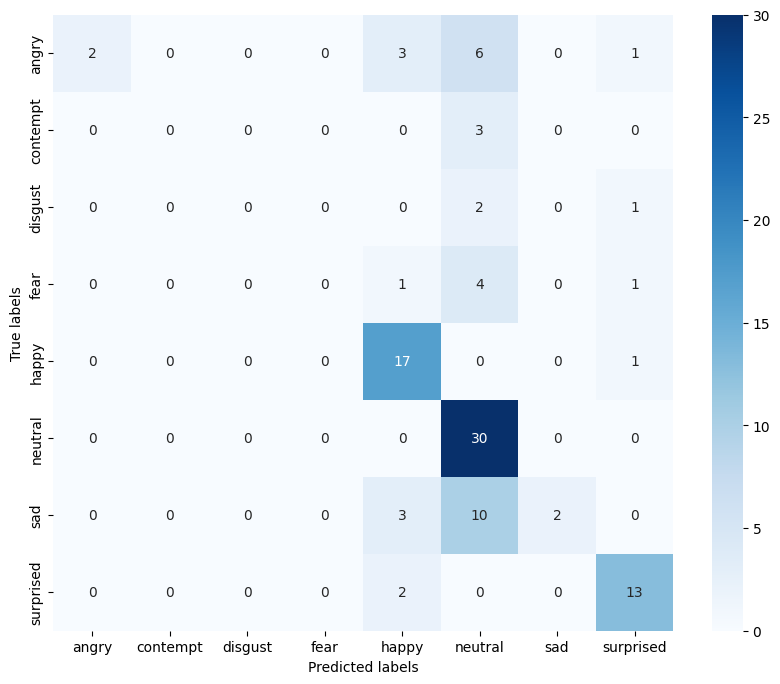

In [ ]:
confusion_matrix = torch.zeros(8, 8).cuda()
batch_cpu = next(tf_val_iter)
batch_gpu = move_to_cuda(batch_cpu)

pred = network(batch_gpu[0])['label'].argmax(dim=1, keepdim=True)
ground_truth = batch_gpu[1].argmax(dim=1,keepdim=True)
for j in range(len(pred)):
  confusion_matrix[ground_truth[j], pred[j]] += 1

# Define class labels
labels = ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Create heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
Train_Count = Classes_Count(tf_train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(tf_val_dir, 'Validation').transpose().sort_values(by="Validation", ascending=False)
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Validation
neutral,76,31
happy,49,19
surprised,38,16
sad,37,16
angry,31,13
fear,23,7
contempt,15,4
disgust,14,4


<Axes: >

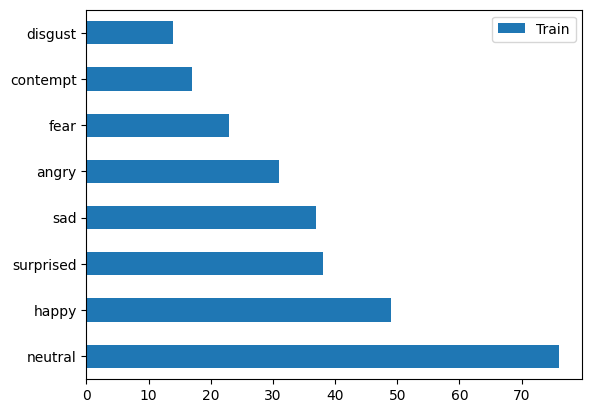

In [ ]:
Train_Count.plot(kind='barh')

<Axes: >

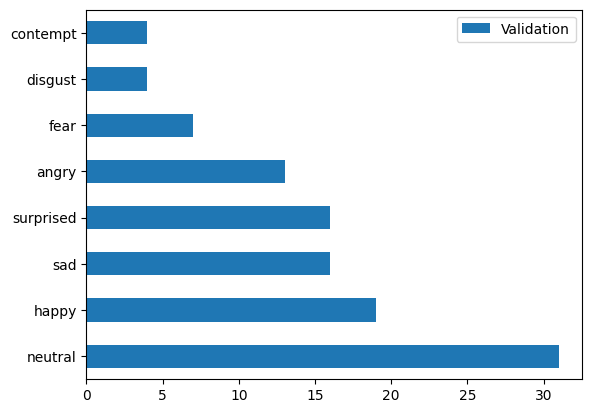

In [ ]:
Test_Count.plot(kind='barh')